In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("food_sales.csv", encoding="utf-8-sig")
weather = pd.read_csv("df_weather.csv", encoding="utf-8-sig")
hol = pd.read_csv("df_holiday.csv", encoding="utf-8-sig")




In [2]:
#处理 BOM、日期格式统一

df.columns = df.columns.str.replace("\ufeff", "", regex=False)
weather.columns = weather.columns.str.replace("\ufeff", "", regex=False)
hol.columns = hol.columns.str.replace("\ufeff", "", regex=False)

df["日期"] = pd.to_datetime(df["日期"])
weather["ds"] = pd.to_datetime(weather["ds"])
hol["date"] = pd.to_datetime(hol["date"])

In [3]:
#选菜品+对可能的日期做预定义
dish_name = "麻辣味黔鱼"
df_one = df.loc[df["菜品"] == dish_name, ["日期", "销量"]].copy()

df_prophet = (
    df_one.groupby("日期", as_index=False)["销量"].sum()
    .rename(columns={"日期": "ds", "销量": "y"})
    .sort_values("ds")
)

# 缺失日期怎么定义：这里假设缺失=0（若缺失=未知，就不要 fillna(0)）
full_ds = pd.date_range(df_prophet["ds"].min(), df_prophet["ds"].max(), freq="D")
df_prophet = (
    df_prophet.set_index("ds").reindex(full_ds).rename_axis("ds").reset_index()
)
df_prophet["y"] = df_prophet["y"].fillna(0.0)


In [4]:
#处理holiday数据
holidays = (
    hol.rename(columns={"date": "ds", "holiday_name": "holiday"})[
        ["ds", "holiday", "lower_window", "upper_window"]
    ]
    .copy()
)

# 没有节假日名的行不要喂给 Prophet
holidays = holidays[holidays["holiday"].fillna("").ne("")]


In [5]:
# 只保留需要的天气列
weather_cols = ["ds", "rain_mm", "avg_temp_c", "avg_humidity_pct"]
weather = weather[weather_cols].copy()

df_train_all = df_prophet.merge(weather, on="ds", how="left")

# 简单缺失处理：用前向填充 + 仍缺则用训练均值
for c in ["rain_mm", "avg_temp_c", "avg_humidity_pct"]:
    df_train_all[c] = df_train_all[c].ffill()
    df_train_all[c] = df_train_all[c].fillna(df_train_all[c].mean())


留出最后 14 天做评估（先别只看 plot）

In [6]:
horizon = 14
train = df_train_all.iloc[:-horizon].copy()
test = df_train_all.iloc[-horizon:].copy()


Prophet + regressors(天气)

In [7]:
from prophet import Prophet

m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,   # 后面可以对比 "auto"
    daily_seasonality=False,
    holidays=holidays,
)

for c in ["rain_mm", "avg_temp_c", "avg_humidity_pct"]:
    m.add_regressor(c)

m.fit(train)


23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:08 - cmdstanpy - INFO - Chain [1] done processing


预测与评估（predict 的 dataframe 必须含 regressors）

In [8]:
future = m.make_future_dataframe(periods=horizon, freq="D", include_history=True)

# 预测期天气：这里用“test 中真实天气”做离线实验
future = future.merge(
    df_train_all[["ds", "rain_mm", "avg_temp_c", "avg_humidity_pct"]],
    on="ds",
    how="left",
)

# 如果 future 里 regressors 还有缺失，先填充（真实上线你会用 API 补齐）
for c in ["rain_mm", "avg_temp_c", "avg_humidity_pct"]:
    future[c] = future[c].ffill()
    future[c] = future[c].fillna(train[c].mean())

forecast = m.predict(future)

pred = forecast.merge(test[["ds", "y"]], on="ds", how="right")
pred["ae"] = (pred["y"] - pred["yhat"]).abs()
pred["ape"] = pred["ae"] / pred["y"].replace(0, np.nan)

mae = pred["ae"].mean()
mape = pred["ape"].mean()

mae, mape


(6.55105838370532, 0.3076737183018845)

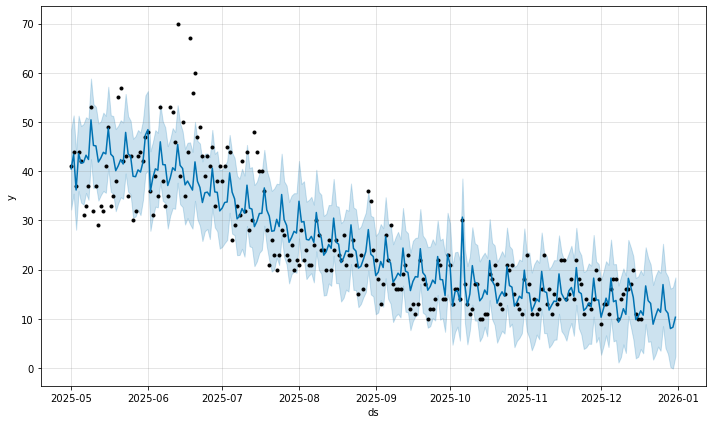

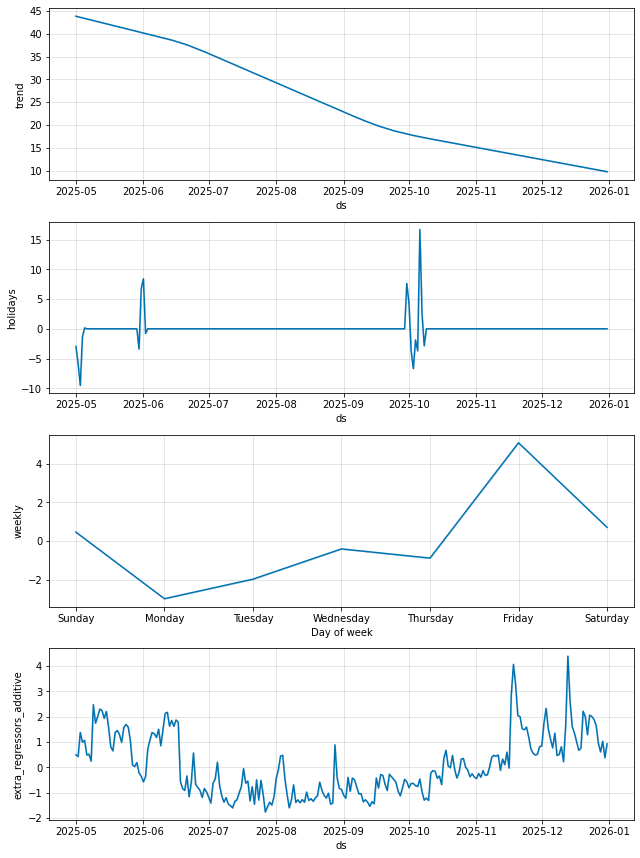

In [9]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
